In [ ]:
# default_exp regressor

# module name here

> API details.

In [ ]:
#export
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import sklearn.ensemble as forest
import GPyOpt
import GPy
import math
import scipy
import time
from scipy.cluster import hierarchy as hc

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
filename = "Train_cleaned.csv"           # dataframe containing all the data
#y_col_name = 'SalePrice'         # name of the column we are going to predict
#split_pct = 0.2             # size of verification dataset
#max_train_time_s = 20         # maximum runtime for one epoch of the data. If it takes longer, the data is cut during search
#time_series = False          # used for validation set, if true, the last split_pct is used, otherwize, random sampled validation
max_iter = 50             # maximum number of tries to find optimal hyper parameters
nfold = 3                 #number of tests for each set of hyper-parameters to get a more stable result

In [ ]:
df = pd.read_csv(filename,low_memory=False)

# Handle Data

In [ ]:
#export
def split_data(df_x, df_y, pct):
    "Splits the data into train and validation set"
    " pct: 0-1 depending on how much that is in validation set"
    df_x.reset_index(inplace=True, drop=True)
    df_y.reset_index(inplace=True, drop=True)

    l = int(len(df_x) * pct)
    x_train = df_x.iloc[:-l]
    x_valid = df_x.iloc[-l:]
    y_train = df_y.iloc[:-l]
    y_valid = df_y.iloc[-l:]
    return x_train, y_train, x_valid, y_valid

def split_data_by_time(df, y_col_name, split_pct=0.2, sampled_time=0, time_series=False, max_train_time_s=np.inf):
    """
    splits the data into smaller size if it takes too long to make one test-run
    """
    if not time_series:
        df = df.sample(frac=1.0).reset_index(drop=True)
    if max_train_time_s < sampled_time:
        psamp = max_train_time_s/sampled_time
        df_samp = df.sample(frac = psamp)
        print(f'Pruning data to len: {len(df)}')
    else:
        df_samp = df
    df_y_samp = df_samp[y_col_name]
    df_x_samp = df_samp.drop(y_col_name, axis=1)
    return  split_data(df_x_samp, df_y_samp, split_pct)

In [ ]:
x_train, y_train, x_valid, y_valid = split_data_by_time(df,'SalePrice', sampled_time=10, max_train_time_s = 5)
assert len(x_train) + len(x_valid) == len(df)//2
x_train, y_train, x_valid, y_valid = split_data_by_time(df, 'SalePrice')
assert len(x_train) + len(x_valid) == len(df)

data = split_data_by_time(df,'SalePrice')
assert len(data) == 4

Pruning data to len: 401125


In [ ]:
#export
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [ ]:
#export
class RfRegressor():
    def __init__(self, df:pd.DataFrame,
                     y_col_name,
                     time_series = False,
                     split_pct = 0.2, 
                     max_train_time_s:int=np.inf):
        # df: dataframe
        # y_col_name         # name of the column we are going to predict
        # split_pct = 0.2     # size of verification dataset
        # max_train_time_s = 20         # maximum runtime for one epoch of the data. If it takes longer, the data is cut during search
        # time_series = False     If set to True, the last part of the dataframe is used as validation otherwise, it's randomized

        self.df=df
        self.y_col_name = y_col_name
        self.max_train_time_s = max_train_time_s
        self.split_pct = split_pct
        self.time_series = time_series
        
        self.model_class = RandomForestRegressor
        self.model = None
        self.train_time = 0
        self.fit_time = 0
        
    def predict(self, df:pd.DataFrame):
        """
        param df: dataframe containing data as input for the model
        returns: array of predictions, array of confidence
        """
        preds = np.stack([t.predict(df) for t in self.model.estimators_])
        conf = np.std(preds, axis=0)
        pred = np.mean(preds,axis=0)
        return pred,conf

    def print_score(self, data:tuple):
        x_train, y_train, x_valid, y_valid = data
        train_preds, train_stds = self.predict(x_train)
        train_rmse = rmse(train_preds, y_train)
        train_score = self.model.score(x_train,y_train)
        text = f"train: rmse:{train_rmse:.5f} std:{train_stds.mean():.5f} score:{train_score:.5f}\n"
        
        valid_preds, valid_stds = self.predict(x_valid)
        valid_rmse = rmse(valid_preds, y_valid)    
        valid_score = self.model.score(x_valid,y_valid)
        text = f"{text}valid: rmse:{valid_rmse:.5f} std:{valid_stds.mean():.5f} score:{valid_score:.5f}\n"
        if hasattr(self.model, 'oob_score_'):
            text =f"{text}oob_score:{self.model.oob_score:.5f}"
        print(text)
        return valid_rmse, valid_stds.mean()

        
    def run_rf_regressor(self, min_sample_leaf:int=4, n_estimators:int=40, sample_frac:float=0.2, max_features:float=0.5):
        """
        todo, set max num samples to speed up the classification
        """
        min_sample_leaf=int(min_sample_leaf)
        n_estimators = int(n_estimators)
        max_train_time_s = np.inf if self.train_time is None else self.max_train_time_s 
        data = split_data_by_time(self.df, 
                                  y_col_name=self.y_col_name,
                                  split_pct=self.split_pct,
                                  time_series=self.time_series,
                                  sampled_time=self.train_time, 
                                  max_train_time_s=max_train_time_s)
        t_start = time.time()
        x_train, y_train, x_valid, y_valid = data
        set_rf_samples(int(len(x_train)*sample_frac))
        self.model = self.model_class(n_estimators=n_estimators, 
                                  n_jobs=-1,
                                  oob_score=True, 
                                  min_samples_leaf=min_sample_leaf,
                                  max_features=max_features)
        
        self.model.fit(x_train, y_train)
        self.train_time = time.time() - t_start
        rmse, std = self.print_score(data)
        self.fit_time = time.time() - t_start
        return rmse, std
    
    def feature_importance(self):
        """ returns a dataframe containing all columns together with feature importance"""
        return pd.DataFrame({'cols':self.df.drop(self.y_col_name,axis=1).columns, 'imp':self.model.feature_importances_}
                       ).sort_values('imp', ascending=False)
    
    def plot_fi(self, df_fi:pd.DataFrame,**kwargs): 
        return df_fi.plot('cols', 'imp', 'barh', legend=False, **kwargs)
    
    def drop_cols_low_importance(self, tresh=0.005):
        df_feat = rfmodel.feature_importance()
        cols_to_drop = df_feat[df_feat['imp']<tresh]['cols']
        self.df = self.df.drop(cols_to_drop, axis=1).copy()

In [ ]:
df_small = df[:20000]
rfmodel = RfRegressor(df_small,
                     y_col_name='SalePrice')
res = rfmodel.run_rf_regressor()
res

train: rmse:0.15081 std:0.18267 score:0.95375
valid: rmse:0.23375 std:0.22847 score:0.89208
oob_score:1.00000


(0.23374504250435352, 0.22846611690074015)

In [ ]:
assert len(res)==2
assert rfmodel.train_time != 0
assert rfmodel.fit_time != 0

# Feature Importance

In [ ]:
df_feat = rfmodel.feature_importance()
df_feat.head()

,cols,imp
20,Enclosure,0.135016
38,Coupler_System,0.124432
6,YearMade,0.106675
40,Hydraulics_Flow,0.071198
15,fiProductClassDesc,0.067256


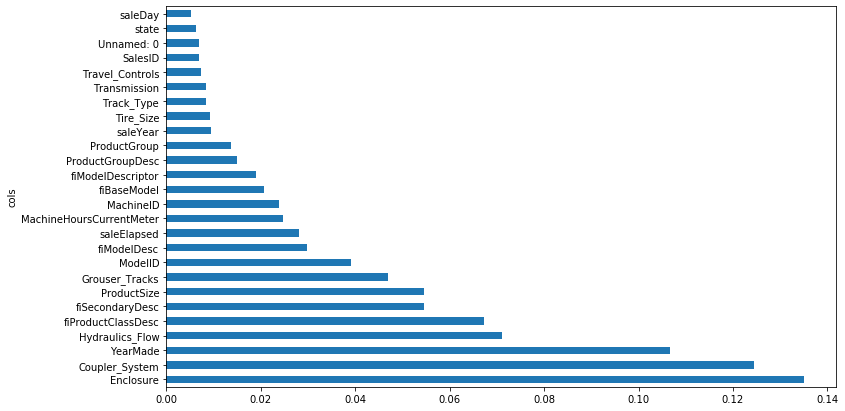

In [ ]:
rfmodel.plot_fi(df_feat[df_feat['imp']>0.005])

In [ ]:
org_num_cols = len(rfmodel.df.columns)
rfmodel.drop_cols_low_importance()
num_cols = len(rfmodel.df.columns)
assert org_num_cols > num_cols*2

# Highly Correlated Variables
Variables that gives the same information (but might be x and log(x)) can confuse the model and need to be removed.
This is a way to find the variables

In [ ]:
#export
class CorrelatedColumns:
    def __init__(self,df:pd.DataFrame):
        self.df = df
        self.corr = np.round(scipy.stats.spearmanr(self.df).correlation, 4)

    
    def plot_var_linkage(self):
        corr_condensed = hc.distance.squareform(1-self.corr)
        z = hc.linkage(corr_condensed, method='average')
        dendrogram = hc.dendrogram(z, labels=self.df.columns, orientation='left', leaf_font_size=16)
        plt.show()
        
    def plot_correlation_heatmap(self):
        f=plt.gcf()
        plt.matshow(self.corr, fignum=f.number)
        plt.xticks(range(self.df.shape[1]), self.df.columns, fontsize=14, rotation=90)
        plt.yticks(range(self.df.shape[1]), self.df.columns, fontsize=14)
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=14)  
    
    def _get_list_of_high_corr(self, corr_limit):
        p = np.argwhere(np.triu(np.abs(self.corr)>corr_limit,1))
        l = list(p)
        return l
    
    @staticmethod
    def _del_param_in_array(arr, value):
        for i in range(len(arr)-1,0,-1):
            if arr[i-1][0] == value:
                del arr[i-1]
                    
    def _del_duplicated_columns(self,arr):
        i=0
        while(i<len(arr)):
            self._del_param_in_array(arr,arr[i][1])
            i+=1
        return arr
    
    def _arrays_to_colnames(self,arr):
        data = dict()
        for i in range(len(arr)):
            temp = data.get(arr[i][0],list())
            if len(temp)==0:
                colname = self.df.columns[arr[i][0]]
                temp.append(colname)
            colname = self.df.columns[arr[i][1]]
            temp.append(colname)
            data[arr[i][0]]  = temp
        ret = [ data[k] for k in data.keys()]
        return ret
    
    def get_pairs(self, corr_limit = 0.98):
        l = self._get_list_of_high_corr( corr_limit)
        self._del_duplicated_columns(l)

        return self._arrays_to_colnames(l)
        

### graph explanation
The graph below tells us the correlation of parameters in the input dataset.
Sale_Year and saleElapsed are almost identical, Unnamed:0 and SalesID are also highly similar

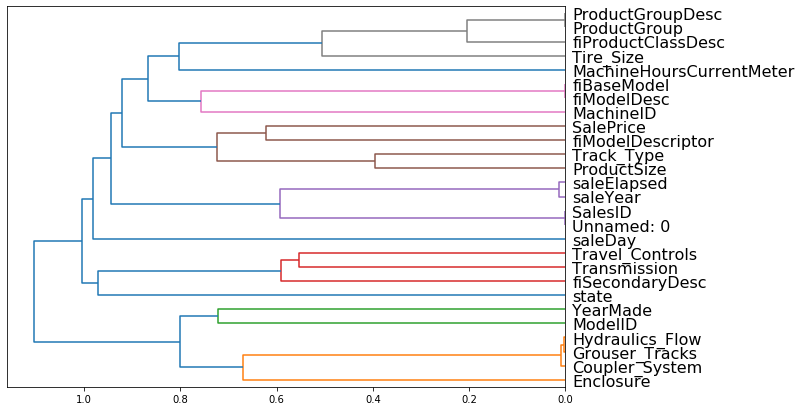

In [ ]:
corr = CorrelatedColumns(rfmodel.df)
plt.figure(figsize=(10,7))
corr.plot_var_linkage()

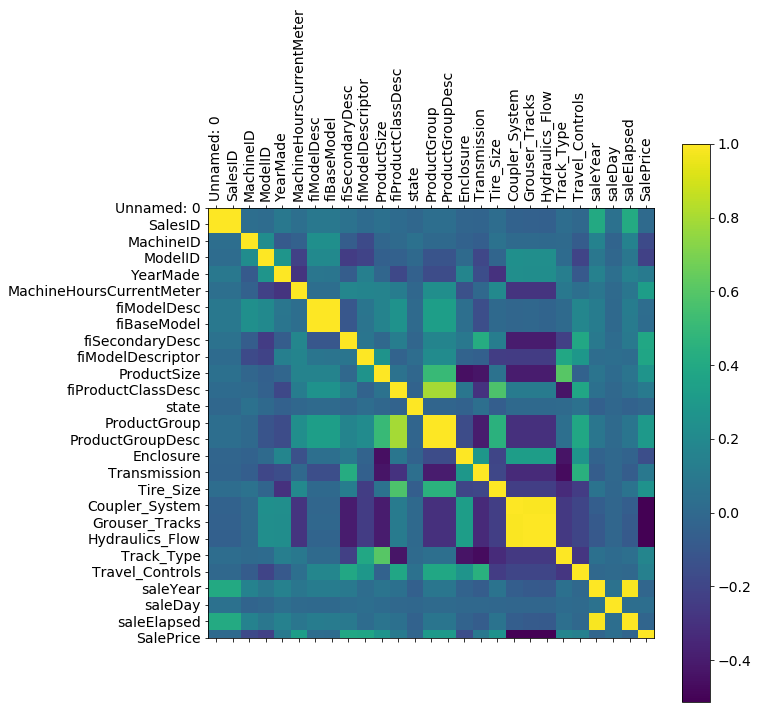

In [ ]:
plt.figure(figsize=(10,10))
corr.plot_correlation_heatmap()

In [ ]:
corr.get_pairs()

[['Unnamed: 0', 'SalesID'],
 ['fiModelDesc', 'fiBaseModel'],
 ['ProductGroup', 'ProductGroupDesc'],
 ['Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow'],
 ['saleYear', 'saleElapsed']]

# gpyopt optimizer

In [ ]:
#export
class RfOptimizer:
    domain       =[{'name': 'min_sample_leaf',      'type': 'continuous', 'domain': (2., 10.)},
               {'name': 'n_estimators','type': 'continuous', 'domain': (10.,100.)},
               {'name': 'sample_frac',  'type': 'continuous', 'domain': (0.1, 0.9)},
               {'name': 'max_features','type' : 'continuous', 'domain': (0.1, 1.0)}]
    def x_to_dict(self, x):
        return { d['name']:var for d, var in zip(self.domain,x)}
    
    def __init__(self,df: pd.DataFrame,
                y_col_name:str,
                time_series=False,
                split_pct=0.2,
                max_train_time_s: int = np.inf,
                max_iter=50):
        self.max_iter = max_iter
        self.opt=None
        self.rfmodel = RfRegressor(df, 
                                   y_col_name=y_col_name, 
                                   time_series=time_series, 
                                   split_pct=split_pct, 
                                   max_train_time_s=max_train_time_s)
        

    
    def _fit_rf(self,x):
        fs = np.zeros((x.shape[0],1))
        for i in range(x.shape[0]):   # usually we only get one row of parameters for each call
            fs[i] = 0
            print(" ")
            rmse, std = self.rfmodel.run_rf_regressor(**self.x_to_dict(x[i]))
            print(f"{rmse:.5f}  {rmse*std:.5f}")
            #for n in range(nfold):  # run fit 3 times to get a more stable result
            #    print(n)
            #    fs[i] += run_rf_regressor(data, **x_to_dict(x[i]))
            #fs[i] *= 1./nfold
            #print(fs[i])
        return rmse
    
    def run_optimizer(self,acquisition_weight=0.2):
        self.opt = GPyOpt.methods.BayesianOptimization(f = self._fit_rf,            # function to optimize       
                                          domain = self.domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = acquisition_weight)   # Exploration exploitation
        self.opt.run_optimization(max_iter=self.max_iter)
    def plot_convergence(self):
        if self.opt is not None:
            self.opt.plot_convergence()
            
        
    

In [ ]:
" todo, fix fit-function"
" todo, add logger"

' todo, add logger'

In [ ]:
ropt = RfOptimizer(df_small, 'SalePrice', max_iter=5)

In [ ]:
ret = ropt.x_to_dict([1,2,3,4])
assert ret['min_sample_leaf'] == 1
assert ret['n_estimators'] == 2
assert ret['sample_frac'] == 3
assert ret['max_features'] == 4

In [ ]:
ropt.run_optimizer()

 
train: rmse:0.13114 std:0.21317 score:0.96526
valid: rmse:0.24269 std:0.28303 score:0.88053
oob_score:1.00000
0.24269  0.06869
 
train: rmse:0.20033 std:0.17748 score:0.91898
valid: rmse:0.24153 std:0.20058 score:0.88141
oob_score:1.00000
0.24153  0.04845
 
train: rmse:0.17184 std:0.20702 score:0.94049
valid: rmse:0.24702 std:0.25010 score:0.87503
oob_score:1.00000
0.24702  0.06178
 
train: rmse:0.15445 std:0.20809 score:0.95200
valid: rmse:0.23535 std:0.26017 score:0.88588
oob_score:1.00000
0.23535  0.06123
 
train: rmse:0.18801 std:0.20129 score:0.92864
valid: rmse:0.24945 std:0.23738 score:0.87350
oob_score:1.00000
0.24945  0.05922
 
train: rmse:0.15891 std:0.21317 score:0.94918
valid: rmse:0.24904 std:0.26480 score:0.87234
oob_score:1.00000
0.24904  0.06595
 
train: rmse:0.19921 std:0.16367 score:0.91963
valid: rmse:0.24839 std:0.18262 score:0.87611
oob_score:1.00000
0.24839  0.04536
 
train: rmse:0.15498 std:0.20928 score:0.95169
valid: rmse:0.24117 std:0.26244 score:0.88000
oob

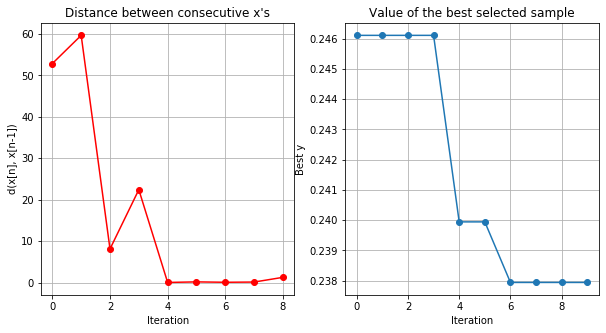

In [ ]:
ropt.plot_convergence()

In [ ]:
from nbdev import *

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
